https://huggingface.co/docs/diffusers/main/en/tutorials/basic_training#train-the-model

In [1]:
import diffusers 
from diffusers.optimization import get_cosine_schedule_with_warmup
from diffusers.utils import make_image_grid
from diffusers import DDPMPipeline
import numpy as np 
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import os
from PIL import Image, ImageDraw
from dataclasses import dataclass
from accelerate import Accelerator
from tqdm.auto import tqdm
from pathlib import Path
import json
import random

/home/sonia/miniconda3/envs/svd/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Image model

In [2]:
@dataclass
class TrainingConfig:
    image_size = 32  # the generated image resolution
    train_batch_size = 16
    eval_batch_size = 16  # how many images to sample during evaluation
    num_epochs = 500
    gradient_accumulation_steps = 8
    learning_rate = 1e-4
    lr_warmup_steps = 500
    save_image_epochs = 1
    save_model_epochs = 1
    mixed_precision = "fp16"  # `no` for float32, `fp16` for automatic mixed precision
    output_dir = "debug"  # the model name locally and on the HF Hub
    seed = 0


config = TrainingConfig()

In [3]:
unet = diffusers.UNet2DModel(
    sample_size        = 32,      # 32×32 tiles
    in_channels        = 1,       # wind magnitude only
    out_channels       = 1,
    block_out_channels = (32, 64, 128),   # 3 resolution scales: 32→16→8
    layers_per_block   = 2,
    down_block_types   = ("DownBlock2D",
                          "AttnDownBlock2D",
                          "AttnDownBlock2D"),
    up_block_types     = ("AttnUpBlock2D",
                          "AttnUpBlock2D",
                          "UpBlock2D"),
    # cross_attention_dim= 0 # no text conditioning
)

In [4]:
class DummyDataset(Dataset):
    def __init__(self, dataset, 
                 width=32, height=32, channels=3, sample_frames=8):
        """
        Args:
            num_samples (int): Number of samples in the dataset.
            channels (int): Number of channels, default is 3 for RGB.
        """
        # Define the path to the folder containing video frames
        self.base_folder = dataset
        self.folders = [f for f in os.listdir(self.base_folder) if os.path.isdir(os.path.join(self.base_folder, f))]
        self.num_samples = len(self.folders)
        self.channels = channels
        self.width = width
        self.height = height
        self.sample_frames = sample_frames

    def __len__(self):
        return self.sample_frames * len(self.folders)

    def __getitem__(self, idx):
        """
        Args:
            idx (int): Index of the sample to return.

        Returns:
            dict: A dictionary containing the 'pixel_values' tensor of shape (16, channels, 320, 512).
        """
        # Randomly select a folder (representing a video) from the base folder
        folder_idx = idx // self.sample_frames
        frame_idx = idx % self.sample_frames
        frame_path = os.path.join(self.base_folder, self.folders[folder_idx], f'{frame_idx}.npy')
        
        # Initialize a tensor to store the pixel values (3 channels is baked into model)
        # pixel_values = torch.empty((self.sample_frames, 3, self.height, self.width))

        with Image.fromarray(np.load(frame_path)) as img:
            # Resize the image and convert it to a tensor
            img_resized = img.resize((self.width, self.height))
            img_tensor = torch.from_numpy(np.array(img_resized)).float()
            img_tensor[img_tensor.isnan()] = 0.0
            if img_tensor.isnan().sum()>0:
                raise ValueError(
                    f"{img_tensor.isnan().sum()} NaN values found in the image tensor for frame {frame_name} in folder {chosen_folder}.")
            elif img_tensor.isinf().sum()>0:
                raise ValueError(
                    f"Inf values found in the image tensor for frame {frame_name} in folder {chosen_folder}.")

            # Normalize the image by scaling pixel values to [-1, 1]
            img_normalized = img_tensor / 255

        return {'pixel_values': img_normalized.unsqueeze(0)}
    
dataset = DummyDataset(dataset='/home/cyclone/train/windmag_atlanticpacific', channels=1)
dataloader = DataLoader(dataset, batch_size=16, shuffle=True)

In [5]:
optimizer = torch.optim.AdamW(unet.parameters(), lr=config.learning_rate)
lr_scheduler = get_cosine_schedule_with_warmup(
    optimizer=optimizer,
    num_warmup_steps=config.lr_warmup_steps,
    num_training_steps=(len(dataloader) * config.num_epochs),
)

In [6]:
def evaluate(config, epoch, pipeline):
    # Sample some images from random noise (this is the backward diffusion process).
    # The default pipeline output type is `List[PIL.Image]`
    images = pipeline(
        batch_size=config.eval_batch_size,
        generator=torch.Generator(device='cpu').manual_seed(config.seed), 
        # Use a separate torch generator to avoid rewinding the random state of the main training loop
    ).images
    
    images = [Image.fromarray(255*np.array(image)) for image in images]

    # Make a grid out of the images
    image_grid = make_image_grid(images, rows=4, cols=4)

    # Save the images
    test_dir = os.path.join(config.output_dir, "samples")
    os.makedirs(test_dir, exist_ok=True)
    image_grid.save(f"{test_dir}/{epoch:04d}.png")

In [ ]:
def train_loop(config, model, noise_scheduler, optimizer, train_dataloader, lr_scheduler):
    accelerator = Accelerator(
        mixed_precision=config.mixed_precision,
        gradient_accumulation_steps=config.gradient_accumulation_steps,
        log_with="tensorboard",
        project_dir=os.path.join(config.output_dir, "logs"),
    )
    if accelerator.is_main_process:
        if config.output_dir is not None:
            os.makedirs(config.output_dir, exist_ok=True)
        accelerator.init_trackers("train_example")
        
    model, optimizer, train_dataloader, lr_scheduler = accelerator.prepare(
        model, optimizer, train_dataloader, lr_scheduler
    )
    
    global_step = 0
    for epoch in range(config.num_epochs):
        progress_bar = tqdm(total=len(train_dataloader), disable=not accelerator.is_local_main_process)
        progress_bar.set_description(f"Epoch {epoch}")
        
        for step, batch in enumerate(train_dataloader):
            clean_images = batch["pixel_values"]
            noise = torch.randn(clean_images.shape, device=clean_images.device)
            bs = clean_images.shape[0]
            
            timesteps = torch.randint(
                0, noise_scheduler.config.num_train_timesteps, (bs,), device=clean_images.device,
                dtype=torch.int64
            )
            noisy_images = noise_scheduler.add_noise(clean_images, noise, timesteps)
            
            with accelerator.accumulate(model):
                # Predict the noise residual
                noise_pred = model(noisy_images, timesteps, return_dict=False)[0]
                loss = F.mse_loss(noise_pred, noise)
                accelerator.backward(loss)

                if accelerator.sync_gradients:
                    accelerator.clip_grad_norm_(model.parameters(), 1.0)
                optimizer.step()
                lr_scheduler.step()
                optimizer.zero_grad()
                
            progress_bar.update(1)
            logs = {"loss": loss.detach().item(), "lr": lr_scheduler.get_last_lr()[0], "step": global_step}
            progress_bar.set_postfix(**logs)
            accelerator.log(logs, step=global_step)
            with open(os.path.join(config.output_dir, 'train_log.txt'), 'a') as f:
                f.write(f"Epoch {epoch}, Step {step}, Loss: {logs['loss']}, LR: {logs['lr']}\n")
            global_step += 1
        
        # sample demo images, save model
        if accelerator.is_main_process:
            pipeline = DDPMPipeline(unet=accelerator.unwrap_model(model), scheduler=noise_scheduler)
            if (epoch + 1) % config.save_image_epochs == 0 or epoch == config.num_epochs - 1:
                evaluate(config, epoch, pipeline)
            if (epoch + 1) % config.save_model_epochs == 0 or epoch == config.num_epochs - 1:
                pipeline.save_pretrained(config.output_dir)
            
noise_scheduler = diffusers.DDPMScheduler(num_train_timesteps=1000)
train_loop(config, unet, noise_scheduler, optimizer, dataloader, lr_scheduler)

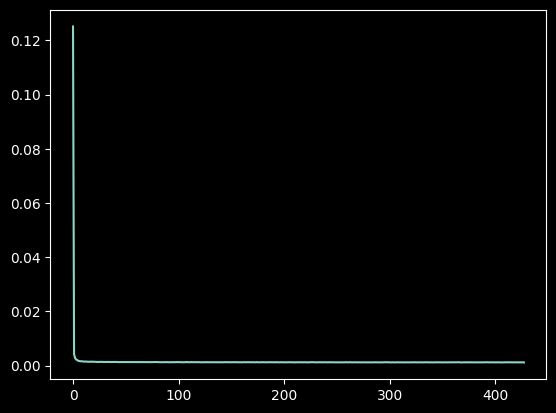

In [1]:
from matplotlib import pyplot as plt 
import numpy as np

with open('/home/sonia/cycloneSVD/debug/train_log.txt', 'r') as f:
    lines = f.readlines()
    
loss_by_epoch = {} 
for l in lines:
    words = l.split()
    epoch = int(words[1][:-1])
    loss = float(words[5][:-1])
    loss_by_epoch[epoch] = loss_by_epoch.get(epoch, []) + [loss]
    
losses = [] 
for epoch in sorted(loss_by_epoch.keys()):
    losses.append(np.mean(loss_by_epoch[epoch]))
    
plt.plot(losses)
# plt.ylim(0,1)

# Video model

In [2]:
config = {
    'image_size': 32,  # the generated image resolution
    'train_batch_size': 1,
    'eval_batch_size': 1,  # how many images to sample during evaluation
    'num_epochs': 2,
    'gradient_accumulation_steps': 8,
    'learning_rate': 1e-7,
    'lr_warmup_steps': 0,
    'save_image_epochs': 1,
    'save_model_epochs': 1,
    'output_dir': "debug",  # the model name locally and on the HF Hub
    'seed': 0,
    'dataset': '/home/cyclone/train/windmag_atlanticpacific',
    'channels': 1, # channels in the images
    'frames': 2,
    'continue': False,
    'cross_attention_dim': 768,
}
dtype = torch.float32 # torch.float16 or torch.float32

In [3]:

class DummyDataset(Dataset):
    def __init__(self, dataset, 
                 width=1024, height=576, channels=3, sample_frames=25):
        """
        Args:
            num_samples (int): Number of samples in the dataset.
            channels (int): Number of channels, default is 3 for RGB.
        """
        # Define the path to the folder containing video frames
        self.base_folder = dataset
        self.folders = [f for f in os.listdir(self.base_folder) if os.path.isdir(os.path.join(self.base_folder, f))]
        self.num_samples = len(self.folders)
        self.channels = channels
        self.width = width
        self.height = height
        self.sample_frames = sample_frames
        
        # get min, max values for normalization
        self.min = np.inf
        self.max = -1 * np.inf
        for folder in self.folders:
            for i in range(sample_frames):
                frame = np.load(os.path.join(self.base_folder, folder, f'{i}.npy'))
                self.min = min(self.min, frame.min())
                self.max = max(self.max, frame.max())
                

    def __len__(self):
        return self.num_samples

    def __getitem__(self, idx):
        """
        Args:
            idx (int): Index of the sample to return.

        Returns:
            dict: A dictionary containing the 'pixel_values' tensor of shape (16, channels, 320, 512).
        """
        # Randomly select a folder (representing a video) from the base folder
        chosen_folder = random.choice(self.folders)
        folder_path = os.path.join(self.base_folder, chosen_folder)
        frames = sorted(os.listdir(folder_path))[:self.sample_frames]

        # Initialize a tensor to store the pixel values (3 channels is baked into model)
        pixel_values = torch.empty((1, self.sample_frames, self.height, self.width))

        # Load and process each frame
        for i, frame_name in enumerate(frames):
            frame_path = os.path.join(folder_path, frame_name)
            # with Image.open(frame_path) as img:
            with Image.fromarray(np.load(frame_path)) as img:
                # Resize the image and convert it to a tensor
                img_resized = img.resize((self.width, self.height))
                img_tensor = torch.from_numpy(np.array(img_resized)).float()
                img_tensor[img_tensor.isnan()] = 0.0
                if img_tensor.isnan().sum()>0:
                    raise ValueError(
                        f"{img_tensor.isnan().sum()} NaN values found in the image tensor for frame {frame_name} in folder {chosen_folder}.")
                elif img_tensor.isinf().sum()>0:
                    raise ValueError(
                        f"Inf values found in the image tensor for frame {frame_name} in folder {chosen_folder}.")

                # Normalize the image by scaling pixel values to [-1, 1]
                img_normalized = 2 * (img_tensor - self.min) / (self.max - self.min) - 1

                pixel_values[:, i, :, :] = img_normalized
        return {'pixel_values': pixel_values}
    


In [4]:
unet2d = diffusers.UNet2DConditionModel.from_pretrained(
        '/home/sonia/cycloneSVD/img1e-7', subfolder='unet', revision='main')
cfg = dict(unet2d.config)
cfg['down_block_types'] = ['3D'.join(name.split('2D')) for name in cfg['down_block_types']]  
cfg['up_block_types'] = ['3D'.join(name.split('2D')) for name in cfg['up_block_types']]  
cfg['mid_block_type'] = '3D'.join(cfg['mid_block_type'].split('2D'))
unet  = diffusers.UNet3DConditionModel.from_config(cfg)

sd2 = unet2d.state_dict()
sd3 = unet.state_dict()
for k, w in sd2.items():
    w3d = sd3.get(k, np.asarray([]))
    if w.ndim == 4 and w3d.ndim==5:                                 # (O, I, H, W)
        w3 = w.unsqueeze(2).repeat(1, 1, config['frames'], 1, 1) # add time dimension
        if time_avg:                                # Ho et al., 2022
            w3 /= config['frames']
        sd3[k] = w3
    elif w.ndim > w3d.ndim:
        sd3[k] = w.squeeze()
    else: # no change
        sd3[k] = w
unet.load_state_dict(sd3, strict=False)
# unet = diffusers.UNet3DConditionModel(
#         sample_size        = 32,      # 32×32 tiles
#         in_channels        = 1,       # wind magnitude only
#         out_channels       = 1,
#         # norm_num_groups    = 1,
#         block_out_channels = [32, 64, 128],   # 3 resolution scales: 32→16→8
#         layers_per_block   = 2,
#         down_block_types   = ["CrossAttnDownBlock3D", "CrossAttnDownBlock3D", "DownBlock3D"],
#         up_block_types     = ["UpBlock3D", "CrossAttnUpBlock3D", "CrossAttnUpBlock3D"],
#         # mid_block_type="UNetMidBlock3D",
#         cross_attention_dim= config['cross_attention_dim'],
#         attention_head_dim=8 # MATCH TO 2D model
#     )
unet = unet.to("cuda", 
               dtype=dtype)

In [5]:
noise_scheduler = diffusers.DDPMScheduler()

dataset = DummyDataset(dataset=config['dataset'], channels=config['channels'], sample_frames=config['frames'],
                       width=config['image_size'], height=config['image_size'])
dataloader = DataLoader(dataset, batch_size=1, shuffle=True)
optimizer = torch.optim.AdamW(
    unet.parameters(),
    lr=config['learning_rate'],)
lr_scheduler = get_cosine_schedule_with_warmup(
    optimizer=optimizer,
    num_warmup_steps=config['lr_warmup_steps'],
    num_training_steps=(len(dataloader) * config['num_epochs']),
)


In [6]:
def train_loop(config, model, noise_scheduler, optimizer, train_dataloader, lr_scheduler):
    accelerator = Accelerator(
        gradient_accumulation_steps=config['gradient_accumulation_steps'],
        log_with="tensorboard",
        project_dir=os.path.join(config['output_dir'], "logs"),
    )
    
    if accelerator.is_main_process:
        os.makedirs(config['output_dir'], exist_ok=True)
        accelerator.init_trackers("train_example")
        
    with open(os.path.join(config['output_dir'], 'config.txt'), 'w') as f:
        json.dump(config, f, indent=4)
        
    model, optimizer, train_dataloader, lr_scheduler = accelerator.prepare(
        model, optimizer, train_dataloader, lr_scheduler
    )
        
    global_step = 0
    for epoch in range(0, config['num_epochs']):
        progress_bar = tqdm(total=len(train_dataloader), disable=not accelerator.is_local_main_process)
        progress_bar.set_description(f"Epoch {epoch}")
        losses = []
        
        for step, batch in enumerate(train_dataloader):
            clean_images = torch.as_tensor(batch["pixel_values"], dtype=dtype)
            zeros = torch.zeros((config['train_batch_size'], 1, config['cross_attention_dim']), dtype=dtype)
            
            noise = torch.randn(clean_images.shape, device=clean_images.device, dtype=dtype)
            bs = clean_images.shape[0]
            timesteps = torch.randint(
                0, noise_scheduler.config['num_train_timesteps'], (bs,), device=clean_images.device,
                dtype=torch.int64
            )
            noisy_images = noise_scheduler.add_noise(clean_images, noise, timesteps)
            # print(noisy_images.shape)
            
            batchlosses = []
            with accelerator.accumulate(model):
                noise_pred = model(noisy_images, timesteps, encoder_hidden_states=zeros.to(clean_images.device), 
                                   return_dict=False)[0]
                loss = F.mse_loss(noise_pred[:,:,1:,:,:], noise[:,:,1:,:,:]) # skip zeroth/prompt frame
                accelerator.backward(loss)

                if accelerator.sync_gradients:
                    accelerator.clip_grad_norm_(model.parameters(), 1.0)
                optimizer.step()
                lr_scheduler.step()
                optimizer.zero_grad()
                
            progress_bar.update(1)
            logs = {"loss": loss.detach().item(), "lr": lr_scheduler.get_last_lr()[0], "step": global_step}
            progress_bar.set_postfix(**logs)
            accelerator.log(logs, step=global_step)
            losses.append(logs['loss'])
            global_step += 1
            
        loss = np.mean(losses)
        with open(os.path.join(config['output_dir'], 'train_log.txt'), 'a') as f:
            f.write(f"Epoch {epoch}, Step {global_step}, Loss: {loss}, LR: {logs['lr']}\n")

In [ ]:
train_loop(config, unet, noise_scheduler, optimizer, dataloader, lr_scheduler)

/home/sonia/miniconda3/envs/svd/lib/python3.11/site-packages/accelerate/accelerator.py:498: UserWarning: `log_with=tensorboard` was passed but no supported trackers are currently installed.
  warnings.warn(f"`log_with={log_with}` was passed but no supported trackers are currently installed.")
Epoch 0:   0%|          | 0/15882 [00:00<?, ?it/s]

Epoch 0:   3%|▎         | 533/15882 [00:27<13:01, 19.64it/s, loss=0.0893, lr=1e-7, step=532]

KeyboardInterrupt: 

Epoch 0:   3%|▎         | 533/15882 [00:40<13:01, 19.64it/s, loss=0.0893, lr=1e-7, step=532]

In [3]:
unet2d.config

FrozenDict([('sample_size', 32),
            ('in_channels', 1),
            ('out_channels', 1),
            ('center_input_sample', False),
            ('flip_sin_to_cos', True),
            ('freq_shift', 0),
            ('down_block_types',
             ['CrossAttnDownBlock2D', 'CrossAttnDownBlock2D', 'DownBlock2D']),
            ('mid_block_type', 'UNetMidBlock2DCrossAttn'),
            ('up_block_types',
             ['UpBlock2D', 'CrossAttnUpBlock2D', 'CrossAttnUpBlock2D']),
            ('only_cross_attention', False),
            ('block_out_channels', [32, 64, 128]),
            ('layers_per_block', 2),
            ('downsample_padding', 1),
            ('mid_block_scale_factor', 1),
            ('dropout', 0.0),
            ('act_fn', 'silu'),
            ('norm_num_groups', 32),
            ('norm_eps', 1e-05),
            ('cross_attention_dim', 768),
            ('transformer_layers_per_block', 1),
            ('reverse_transformer_layers_per_block', None),
            ('e